<a href="https://colab.research.google.com/github/Syilun/face_people_recognization/blob/master/02face_identification_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install mtcnn

In [4]:
import mtcnn
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
from glob import glob
import keras
from keras.layers import Input, Lambda, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
import keras.backend as K
import pickle

Using TensorFlow backend.


In [5]:
FOLDER_PATH = '/content/drive/My Drive/Tibame AI/智揚/week10/face_detection'
IMG_SIZE = 160

In [6]:
detector = MTCNN()
path_train = sorted(glob(os.path.join(FOLDER_PATH, '5celeb/data/train/*/*.jpg')))
path_val = sorted(glob(os.path.join(FOLDER_PATH, '5celeb/data/val/*/*.jpg')))
len(path_train), len(path_val)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



(93, 25)

In [7]:
# extract names
names = []
for path in path_train:
    name = path.split(os.sep)[-2]
    if name not in names:
        names.append(name)
names

['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']

In [8]:
#build class map
cls_map = {}
for i, name in enumerate(names):
    cls_map[name] = int(i)
cls_map

{'ben_afflek': 0,
 'elton_john': 1,
 'jerry_seinfeld': 2,
 'madonna': 3,
 'mindy_kaling': 4}

In [9]:
# load X(img), y(labels)
def load_data(paths):
    X = np.zeros((len(paths), IMG_SIZE, IMG_SIZE, 3))
    y = np.zeros((len(paths), 1), dtype=int)
    for i, path in enumerate(tqdm(paths)):
        img = cv2.imread(path)[:,:,::-1]
        results = detector.detect_faces(img)
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[max(y1, 0): min(y2, img.shape[0]), max(x1, 0): min(x2, img.shape[1])]
        # resize face
        patch = cv2.resize(patch, (IMG_SIZE, IMG_SIZE))
        name = path.split('/')[-2]
        X[i] = patch
        y[i] = cls_map[name]
    return X, y

In [10]:
X_train, y_train = load_data(path_train)
X_val, y_val = load_data(path_val)

In [11]:
# # save file

# with open(os.path.join(FOLDER_PATH, 'X_train.pickle'), 'wb') as file:
#     pickle.dump(X_train, file)
# with open(os.path.join(FOLDER_PATH, 'y_train.pickle'), 'wb') as file:
#     pickle.dump(y_train, file)
# with open(os.path.join(FOLDER_PATH, 'X_val.pickle'), 'wb') as file:
#     pickle.dump(X_val, file)
# with open(os.path.join(FOLDER_PATH, 'y_val.pickle'), 'wb') as file:
#     pickle.dump(y_val, file)

In [12]:
# Method2: load from pickle file
with open(os.path.join(FOLDER_PATH, 'X_train.pickle'), 'rb') as file:
    X_train = pickle.load(file)
with open(os.path.join(FOLDER_PATH, 'y_train.pickle'), 'rb') as file:
    y_train = pickle.load(file)
with open(os.path.join(FOLDER_PATH, 'X_val.pickle'), 'rb') as file:
    X_val = pickle.load(file)
with open(os.path.join(FOLDER_PATH, 'y_val.pickle'), 'rb') as file:
    y_val = pickle.load(file)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((93, 160, 160, 3), (93, 1), (25, 160, 160, 3), (25, 1))

### Preprocess

In [13]:
X_train = X_train / 255.
X_val = X_val / 255.

[0] ben_afflek


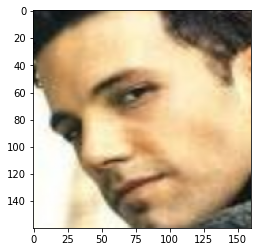

[0] ben_afflek


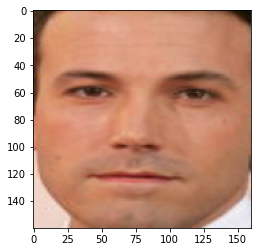

[0] ben_afflek


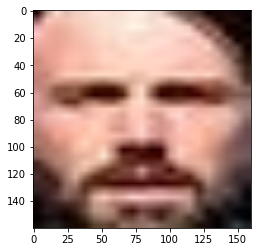

[0] ben_afflek


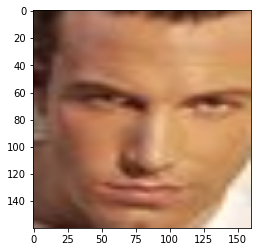

[0] ben_afflek


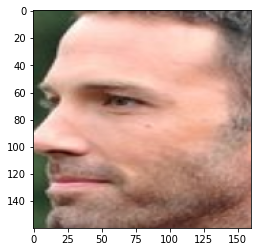

In [14]:
for i in range(X_train.shape[0])[:5]:
    print(y_train[i], names[y_train[i][0]])
    plt.imshow(X_train[i])
    plt.show()

In [15]:
def create_pairs(x, face_indices, num_classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(face_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            # positive pairs
            z1, z2 = face_indices[d][i], face_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            # negative pairs
            inc = np.random.randint(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = face_indices[d][i], face_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

# create training+test positive and negative pairs
face_indices = [np.where(y_train == i)[0] for i in range(len(names))]
train_pairs, train_y = create_pairs(X_train, face_indices, num_classes=len(names))

face_indices = [np.where(y_val == i)[0] for i in range(len(names))]
val_pairs, val_y = create_pairs(X_val, face_indices, num_classes=len(names))

In [16]:
train_pairs.shape, train_y.shape, val_pairs.shape, val_y.shape

((130, 2, 160, 160, 3), (130,), (40, 2, 160, 160, 3), (40,))

In [17]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [18]:
# build model
# network definition
base_network = keras.applications.resnet50.ResNet50(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))

input_a = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
input_b = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
global_avg = GlobalAveragePooling2D()
processed_a = base_network(input_a)
processed_a = global_avg(processed_a)
processed_b = base_network(input_b)
processed_b = global_avg(processed_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

/tensorflow-1.15.2/python3.6/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [19]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 5, 5, 2048)   23587712    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           resnet50[1][0]             

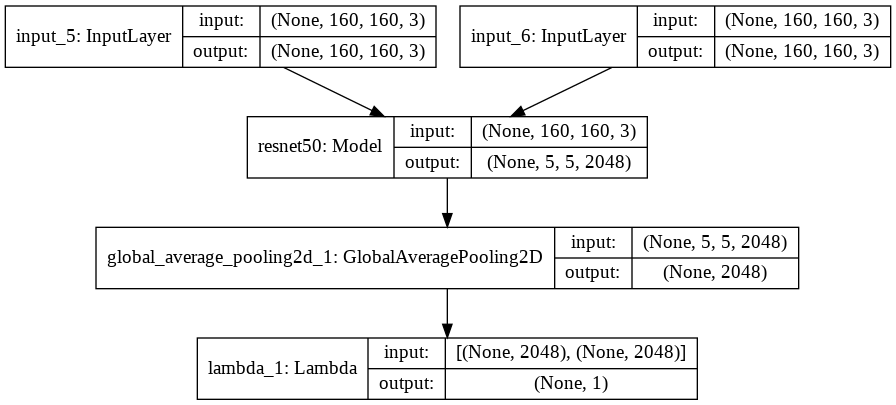

In [20]:
plot_model(model, show_shapes=True)

In [ ]:
earlystop = EarlyStopping(patience=10)
model_ckp = ModelCheckpoint(os.path.join('/content/drive/My Drive', 'model_siamese.h5'), save_best_only=True, save_weights_only=False)

# train
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[])
model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y,
          batch_size=32,
          epochs=1000,
          callbacks=[earlystop, model_ckp],
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

In [22]:
# load model
# method1: compile=False
# model = load_model(os.path.join(FOLDER_PATH, 'model_siamese.h5'), compile=False)
# method 2
model = load_model(os.path.join(FOLDER_PATH, 'model_siamese.h5'), custom_objects={'contrastive_loss': contrastive_loss})

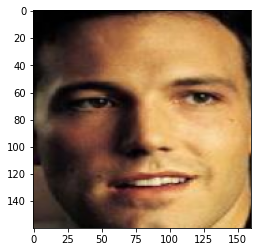

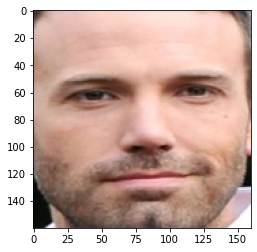

label:  1  val data shape:  (1, 2, 160, 160, 3)
Distance:  [[0.8602383]]


In [28]:
# Evaluation
idx = np.random.randint(0, val_pairs.shape[0])
pair = val_pairs[idx]
label = val_y[idx]
imgA, imgB = pair[0], pair[1]
plt.imshow(imgA)
plt.show()
plt.imshow(imgB)
plt.show()
print('label: ', label, ' val data shape: ',val_pairs[idx:idx+1].shape)
print('Distance: ', model.predict([
  np.expand_dims(imgA, axis=0), np.expand_dims(imgB, axis=0)]))

In [24]:
all_pairs = np.concatenate((train_pairs, val_pairs))
all_labels = np.concatenate((train_y, val_y))

In [25]:
positive_pairs = all_pairs[all_labels == 1]
negative_pairs = all_pairs[all_labels == 0]

In [26]:
positive_distances = model.predict([positive_pairs[:, 0], positive_pairs[:, 1]])
negative_distances = model.predict([negative_pairs[:, 0], negative_pairs[:, 1]])

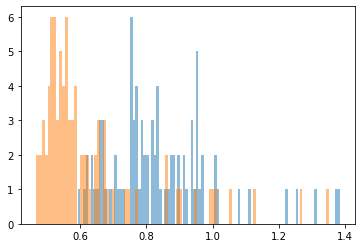

In [27]:
plt.hist(negative_distances[:,0], bins=100, alpha=0.5)
plt.hist(positive_distances[:,0], bins=100, alpha=0.5)
plt.show()